# 1. 필요한 라이브러리 import

In [1]:
import os
import fnmatch
from collections import Counter
import zipfile
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# 2. 데이터 준비
➡️ 초기 1회만 실행

- 파일 압축 해제

In [3]:
zip_file = zipfile.ZipFile('./VideoS4.zip')
zip_file.extractall(path="./data")

- 다른 파일의 압축 해제 및 데이터 병합

In [7]:
# 압축 파일과 대상 디렉토리 경로 설정
zip_file_path = './resnet2.zip'#바꾸기
target_folder_path = './data/VideoS3'

# 임시 디렉토리 생성
temp_folder_path = './dd'
os.makedirs(temp_folder_path, exist_ok=True)

# 압축 파일 풀기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_folder_path)

# 'Video_b3' 폴더 경로 설정
video_folder_path = os.path.join(temp_folder_path, 'resnet2')#바꾸기

# 'Video_b3' 폴더 내부의 파일들을 대상 디렉토리로 복사
for root, _, files in os.walk(video_folder_path):
    for file in files:
        source_file_path = os.path.join(root, file)
        target_file_path = os.path.join(target_folder_path, file)

        # 중복되는 파일이 있을 경우 이름 변경
        if os.path.exists(target_file_path):
            base, extension = os.path.splitext(file)
            counter = 1
            new_file_name = f"{base}_{counter}{extension}"
            new_target_file_path = os.path.join(target_folder_path, new_file_name)
            while os.path.exists(new_target_file_path):
                counter += 1
                new_file_name = f"{base}_{counter}{extension}"
                new_target_file_path = os.path.join(target_folder_path, new_file_name)
            target_file_path = new_target_file_path

        shutil.move(source_file_path, target_file_path)

# 임시 디렉토리 삭제
shutil.rmtree(temp_folder_path)

print("파일 병합이 완료되었습니다.")

파일 병합이 완료되었습니다.


- 손상된 이미지 삭제

In [6]:
folder_path = './data/VideoS3'

# 폴더 내의 모든 파일을 순회
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일 형식을 여기에 추가
        try:
            img = Image.open(os.path.join(folder_path, filename))  # 이미지 열기 시도
            img.verify()  # 이미지가 손상되었는지 확인
        except (IOError, SyntaxError) as e:
            print(f'{filename} is corrupted and will be deleted.')  # 손상된 이미지 파일명 출력
            os.remove(os.path.join(folder_path, filename))  # 손상된 이미지 삭제


# 3. 데이터의 분포 확인
- go/right/left/stop 별 이미지 데이터의 개수 확인
    - index: 090 ➡️ go
    - index: 135 ➡️ right
    - index: 045 ➡️ left
    - index: 180 ➡️ stop

In [13]:
folder_path = './data/VideoS3'

# 이미지 파일 인덱스 집계를 위한 빈 Counter 객체 생성
index_counter = Counter()

# 삭제된 이미지를 제외한 폴더 내의 모든 파일을 순회
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # 이미지 파일 형식을 여기에 추가
        index = filename[12:15]  # 파일명에서 인덱스 추출
            
        index_counter[index] += 1  # 추출된 인덱스에 대한 카운트 증가

# 인덱스별 이미지 개수 출력
for index, count in index_counter.items():
    print(f'Index: {index}, Count: {count}')

Index: 090, Count: 428
Index: 135, Count: 368
Index: 180, Count: 1969
Index: 045, Count: 807


# 4. 데이터를 변수에 저장
- stop데이터 ➡️ stopline = 1으로 라벨링
- go/right/left데이터 ➡️ stopline = 0으로 라벨링

image_path: ./data/VideoS3\train_00044_135.png
steering_Angle: 0


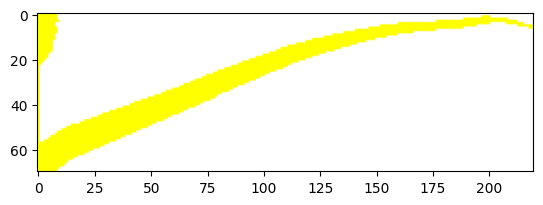

In [16]:
data_dir = './data/VideoS3'
file_list = os.listdir(data_dir)
image_paths = [] # 이미지 경로를 저장하는 변수
stopline_yesno = [] # 이미지 각도를 저장하는 변수
pattern = "*.png" # .png 확장자 가진 파일만 취급

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        file_path = os.path.join(data_dir, filename)
        try:
            # 이미지 파일을 열어보려고 시도
            with Image.open(file_path) as img:
                # 파일이 성공적으로 열렸다면 리스트에 추가
                image_paths.append(file_path)
                if filename[12:15]=='180':
                    stopline = 1
                else:
                    stopline = 0
                stopline_yesno.append(stopline)
        except:
            # 파일 열기에 실패한 경우, 예외가 발생하고 해당 파일은 무시
            print(f"Failed to open {file_path}")


# 이후 과정은 동일하게 진행
image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("steering_Angle: %d" % stopline_yesno[image_index])

df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Stopline'] = stopline_yesno

- stop과 non-stop 데이터의 분포 확인 

In [17]:
# 데이터프레임 생성
df = pd.DataFrame({
    'ImagePath': image_paths,
    'Stopline': stopline_yesno
})

# stopline 값에 따른 분포 확인
distribution = df['Stopline'].value_counts()

print(distribution)


Stopline
1    1824
0    1603
Name: count, dtype: int64


# 5. 전처리 & 데이터 분리 & 모델 선언 & 모델 학습 & 평가 & 저장

In [18]:
import os
import fnmatch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 이미지 로딩 및 전처리
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((70, 220))  # (width, height) 순서
    img = img_to_array(img)
    img /= 255.0  # Normalize the image
    return img

images = np.array([preprocess_image(path) for path in df['ImagePath']])
labels = np.array(df['Stopline'])

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# 라벨 원-핫 인코딩
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# 모바일넷 모델 로드 및 수정
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(220, 70, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 기존 층을 학습하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False
    

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 데이터 증강 설정
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# 모델 학습
batch_size = 32
epochs = 20

model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(X_train) // batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 모델 저장
model.save('./stopline_detection_model.h5')
print("Model saved to stopline_detection_model.h5")

C:\Users\dkgus\AppData\Local\Temp\ipykernel_10572\2588008926.py:35: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(220, 70, 3))


Epoch 1/20


c:\Users\dkgus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 18s 165ms/step - accuracy: 0.8801 - loss: 0.5319 - val_accuracy: 1.0000 - val_loss: 1.0913e-04
Epoch 2/20
 1/85 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 1.0000 - loss: 0.0030

c:\Users\dkgus\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 9.4516e-05
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.9920 - loss: 0.0195 - val_accuracy: 0.9971 - val_loss: 0.0077
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9971 - val_loss: 0.0098
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.9889 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 1.4324e-04
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 5.3293e-04 - val_accuracy: 1.0000 - val_loss: 1.7219e-04
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.9958 - loss: 0.0113 - val_accuracy: 1.0000 - val_loss: 6.0966e-05
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 1.0000 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 2.9162e-04
Epoch 9/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.9909 - loss: 0.0210 - val

Test Accuracy: 100.00%
Model saved to stopline_detection_model.h5


# 6. 데이터 예측 시각화

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


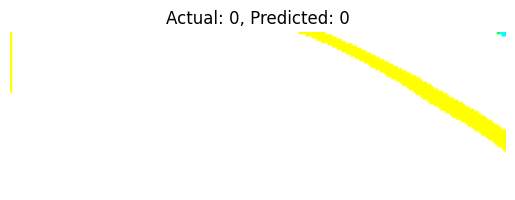

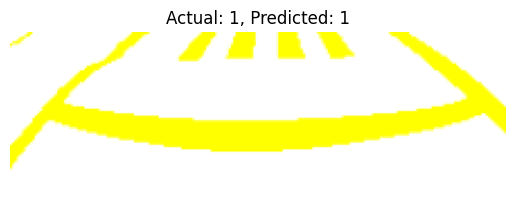

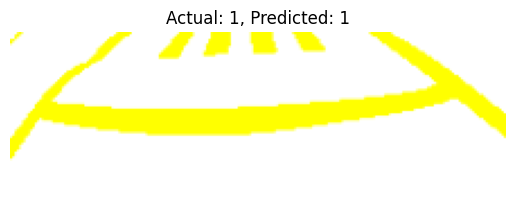

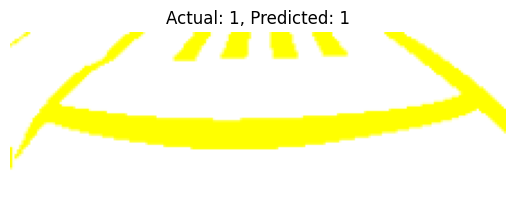

In [20]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 모델 로드
model = tf.keras.models.load_model('./stopline_detection_model.h5')

# 예시 이미지 4개에 대한 실제 값과 예측값 보여주기
example_indices = np.random.choice(len(df), 4, replace=False)
example_images = [preprocess_image(df['ImagePath'].iloc[idx]) for idx in example_indices]
example_images_array = np.array(example_images)
example_labels = df['Stopline'].iloc[example_indices].values

# 예측 수행
predicted_labels = model.predict(example_images_array)

# 실제 값과 예측값 출력
for i in range(4):
    plt.figure()
    img = Image.open(df['ImagePath'].iloc[example_indices[i]])
    img = img.resize((220, 70))  # Resize to match the model's input size
    plt.imshow(img)
    # 원-핫 인코딩된 예측값에서 가장 높은 확률을 가진 인덱스 선택
    predicted_label = np.argmax(predicted_labels[i])
    plt.title(f"Actual: {example_labels[i]}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()
